Лабораторная работа №4

In [ ]:
import numpy as np
from random import random
import math
import os
from os import listdir
from PIL import Image
import matplotlib.pyplot as plt
from random import uniform as uniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
network_layer = 4 #отвечает за количество слоев
neuron_count = [32, 24, 16, 3]

In [ ]:
'''#Гиперболический тангенс
def activate(x):
  return math.tanh(x)

In [ ]:
'''#Производная от гиперболической функции
def dy_activate(x):
  return 1/ math.cosh(x) ** 2

In [ ]:
#Сигмовидная функция активации(позволяют нейронам как усиливать слабые сигналы, так и не насыщаться от сильных сигналов)
def activate(x):
  return 1 / (1 + math.pow(math.e, -x))

In [ ]:
#Relu функция активации(с ней обучение проходит быстрее)
def Rely_activate(x):
  return max(0.0, x)

In [ ]:
#Производная от Relu 
def Rely_dy_activate(x):
  if(x >= 0):
    return 1
  else:
    return 0

In [ ]:
#Производная от сигмоидной фукции
def dy_activate(x):
  return activate(x) * (1 - activate(x))

Функция для работы с картинками

In [ ]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
classA = 0
classB = 2
classC = 3

In [ ]:
from keras.datasets import fashion_mnist

(x_train_fashion , y_train_fashion), (x_test_fashion , y_test_fashion) = fashion_mnist.load_data()
#x_data = np.concatenate((x_train_fashion, x_test_fashion))
#y_data = np.concatenate((y_train_fashion, y_test_fashion))

In [ ]:
train_filter = np.where((y_train_fashion == classA) | (y_train_fashion == classB) | (y_train_fashion == classC))
test_filter = np.where((y_test_fashion == classA) | (y_test_fashion == classB) | (y_test_fashion == classC))

x_train , y_train = x_train_fashion[train_filter] , y_train_fashion[train_filter]
x_test , y_test = x_test_fashion[test_filter] , y_test_fashion[test_filter]

x_train , y_train = x_train[:65] , y_train[:65]# отбор картинок
x_test, y_test = x_test[:15], y_test[:15]

print('x_train: ' , x_train.shape)
print('y_train: ' , y_train.shape)
print('x_test: ' , x_test.shape)
print('y_test: ' , y_test.shape)

x_train:  (65, 28, 28)
y_train:  (65,)
x_test:  (15, 28, 28)
y_test:  (15,)


In [ ]:
print(type(x_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
def OutputImage(x_value, y_value):
  plt.figure(figsize = (15, 8))
  for i in range(32):
    plt.subplot(4 , 8 , i + 1)
    plt.imshow(x_value[i] , cmap = "gray")
    label_index = int(y_train[i])
    plt.title(class_names[label_index])
  plt.show()

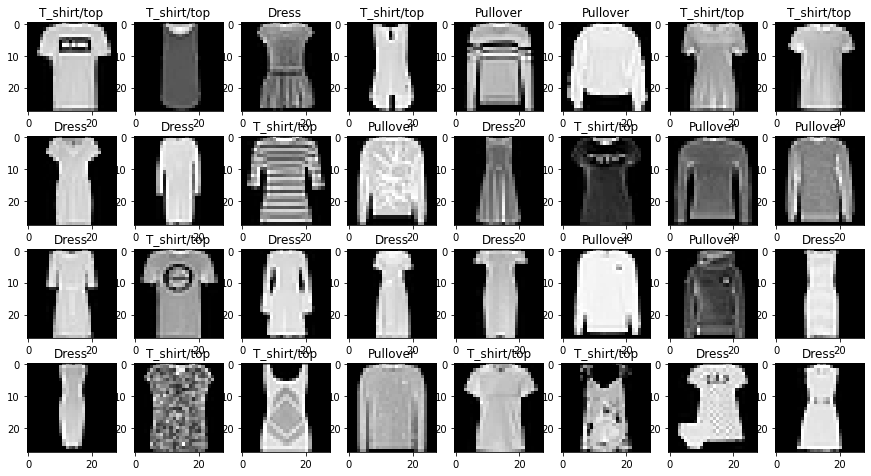

In [ ]:
OutputImage(x_train, y_train)

In [ ]:
#Нормализация картинок
x_train = np.array(x_train , np.float32).reshape([-1 , 784]) / 255.0 
x_test = np.array(x_test , np.float32).reshape([-1 , 784]) / 255.0

#Добавляем 1 в качестве bias
x_train = ([np.append(x_train[i], 1) for i in range(len(x_train))])
x_test = ([np.append(x_test[i], 1) for i in range(len(x_test))])

Функция для работы с dataset

In [ ]:
def mini_batch(x_data, y_data):#в обучение отдаем части выборки, т.е. число кратное 8(аппаратная оптимизация)
  x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.20, stratify=y)
  
  print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
  print(f"Количество строк в y_test по классам: {np.bincount(y_test)}") 
  return x_train, y_train, x_test, y_test

In [ ]:
def fullBatch(x_data, y_data):#всю выборку передает в обучение
  return x_data, y_data

In [ ]:
def rename_y_value(y_value): #метод который меняет метки
  new_mark = []
  for i in range(len(y_value)):
    if(y_value[i] == 0):
      new_mark.append([1, 0, 0])# для классификации
    elif(y_value[i] == 2):
      new_mark.append([0, 1, 0])
    else:
      new_mark.append([0, 0, 1])
  return new_mark

Функции для работы с весами

In [ ]:
#Функция вывода весов
def printWeight(weights, network_layer, neuron_count):
  for i in range(network_layer):
    print("Layer --------------------- {0}".format(i + 1))
    for j in range(neuron_count[i]):
      print("Neuron - {0}".format(j + 1))
      print(weights[i][j])

In [ ]:
#Функция генерирования рандомных весов
def generate_weight(size_of_first_layer, neuron_count):
  weights = []
  for i in range(network_layer):
    weight_layer = []
    for j in range(neuron_count[i]):
      weight_neuron = []

      if(i == 0):
        for m in range(size_of_first_layer):
          weight_neuron.append(uniform(-0.5, 0.5))
      else:
        for m in range(neuron_count[i - 1] + 1):
          weight_neuron.append(uniform(-0.5, 0.5))
      weight_layer.append(weight_neuron)
    weights.append(weight_layer)
  return weights

In [ ]:
weights = generate_weight(len(x_train[0]), neuron_count)#генерируются веса
print(printWeight(weights, network_layer, neuron_count))

In [ ]:
#Функция копирования значений весов
def weights_copy(weights):
  weights_copy = []
  for i in range(len(weights)):
    weights_layer = []
    for j in range(len(weights[i])):
      weights_neuron = []
      for m in range(len(weights[i][j])):
        weights_neuron.append(weights[i][j][m])
      weights_layer.append(weights_neuron)
    weights_copy.append(weights_layer)
  return weights_copy

In [ ]:
weights_bp = weights_copy(weights)

Функция predict

In [ ]:
def predict2_0(weights, x_train, bias):
  output_value_by_every_layer = []
  input_value_by_every_layer = []
  for i in range(len(weights)):
    input_value_of_layer = []
    output_value_of_layer = []

    for j in range(len(weights[i])):
      output_value_neuron = 0

      if(i == 0):
        input_value_neuron = np.dot(weights[i][j], x_train)
      else:
        input_value_neuron = np.dot(weights[i][j], output_value_by_every_layer[i - 1])
      
      if(i != len(weights) - 1):
        output_value_neuron = Rely_activate(input_value_neuron)
      else:
        output_value_neuron = activate(input_value_neuron)
      output_value_of_layer.append(output_value_neuron)
      input_value_of_layer.append(input_value_neuron)

    if(i != len(weights) - 1):
      output_value_of_layer.append(bias)

    input_value_by_every_layer.append(input_value_of_layer)
    output_value_by_every_layer.append(output_value_of_layer)

    '''print("Layer {0}".format(i + 1))
    print("Input value")
    print(input_value_of_layer)
    print("Output value")
    print(output_value_of_layer)'''

  return input_value_by_every_layer, output_value_by_every_layer

In [ ]:
y_train = rename_y_value(y_train)
y_test = rename_y_value(y_test)

print(y_test)
print(y_train)

[[0, 1, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1], [1, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]]
[[1, 0, 0], [1, 0, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [0, 0, 1], [0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 1, 0], [0, 1, 0], [0, 0, 1], [0, 0, 1], [1, 0, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [0, 0, 1], [1, 0, 0], [0, 0, 1], [0, 0, 1], [0, 1, 0]]


Функции Acc, Loss, вывода y-предсказанного

In [ ]:
#Функция расчета значений потери между y-предсказанным и y-тестовым
def err_loss(x, y, weights, bias):
  loss = 0
  last = len(weights) - 1
  for i in range(len(x)):
    y_inp, y_out = predict2_0(weights, x[i], bias)
    for j in range(len(y_out[last])):
      #loss += np.square(y_out[last][y[i].index(max(y[i]))] - max(y[i]))
      loss += np.square(y_out[last][j] - y[i][j])
  loss = np.sqrt(loss) / len(x)
  return loss

In [ ]:
#Функция расчета hitrate
def err_acc(x, y, weights, eps, bias):
  hit = 0
  out = 0
  last = len(weights) - 1
  for i in range(len(x)):
    y_inp, y_out = predict2_0(weights, x[i], bias)
    if(y_out[last].index(max(y_out[last])) == y[i].index(max(y[i]))):
        hit = hit + 1
  return hit / len(x)

In [ ]:
#Функция вывода значений y-предсказанных
def y_out_print(weights, x_test, bias):
  last = len(weights) - 1
  print("y_out: ")
  for i in range(len(x_test)):
    y_predict_input, y_predict_output = predict2_0(weights, x_test[i], bias)
    print(y_predict_output[last])
  print("-----------------------------")

Back propogation

In [ ]:
def back_Propogation2_0(weights, epoch, a, x_train, y_train, x_test, y_test, bias):
  sigma_list = []
  for i in range(len(weights)):
    any_list = []
    for j in range(len(weights[i])):
      any_list.append(0)
    sigma_list.append(any_list)

  last_index = len(weights) - 1
  error = 0
  array_loss = []
  array_acc = []
  for i in range(epoch):
    print("Эпоха №{0}".format(i+ 1))
  
    for j in range(len(x_train)):
      input_value, output_value = predict2_0(weights, x_train[j], bias)
      #print("Веса до: ")
      #print(printWeight(weights, network_layer, [8, 4, 3]))
      #print("y_predict: {0}".format(output_value[last_index]))
      #print("y_true: {0}".format(y_train[j]))
     
      #Выходные нейроны
      for p in range(len(output_value[last_index])):
        error = y_train[j][p] - output_value[last_index][p]
        g = dy_activate(input_value[last_index][p]) * error
        sigma_list[last_index][p] = g
        
        for m in range(len(weights[last_index][p])):
          weights[last_index][p][m] += a * g * output_value[last_index - 1][p]

      #Скрытый слой
      for p in range(last_index - 1, -1, -1):
        for m in range(len(weights[p])):
          sigma = 0
          for k in range(len(weights[p + 1])):
            sigma += weights[p + 1][k][m] * sigma_list[p + 1][k]
          g = sigma * Rely_dy_activate(input_value[p][m])
          sigma_list[p][m] = g

          if(p == 0):
            for k in range(len(weights[p][m])):
              weights[p][m][k] += g * a * x_train[j][k]
          else:
            for k in range(len(weights[p][m])):
              weights[p][m][k] += g * a * output_value[p - 1][k]
      #print("После: ")
      #print(printWeight(weights, network_layer, [8, 4, 3]))

    loss = err_loss(x_test, y_test, weights, bias)#ошибки
    array_loss.append(loss)
    acc = err_acc(x_test, y_test, weights, 0.1, bias)
    array_acc.append(acc)
    print("Loss: {0}".format(loss))
    print("Acc: {0}".format(acc))

    #print("True: {0}".format(y_test))
    #y_out_print(weights, x_test, bias)

  return weights, array_loss, array_acc

In [ ]:
weights_bp, array_loss_bp, array_acc_bp = back_Propogation2_0(weights_bp, 250, 0.01, x_train, y_train, x_test, y_test, 1)

Эпоха №1
Loss: 0.1650161633268943
Acc: 0.7333333333333333
Эпоха №2
Loss: 0.1631618071429305
Acc: 0.8
Эпоха №3
Loss: 0.1676193459072698
Acc: 0.8
Эпоха №4
Loss: 0.167719219296468
Acc: 0.8
Эпоха №5
Loss: 0.1671624007202833
Acc: 0.8
Эпоха №6
Loss: 0.1649059277677148
Acc: 0.8
Эпоха №7
Loss: 0.16680530606459365
Acc: 0.8
Эпоха №8
Loss: 0.16704619819602015
Acc: 0.8
Эпоха №9
Loss: 0.16738175603541655
Acc: 0.8
Эпоха №10
Loss: 0.16568283559487354
Acc: 0.8
Эпоха №11
Loss: 0.16478618644559975
Acc: 0.8
Эпоха №12
Loss: 0.1645421941608494
Acc: 0.8
Эпоха №13
Loss: 0.16473272520502247
Acc: 0.8
Эпоха №14
Loss: 0.16678384107144473
Acc: 0.8
Эпоха №15
Loss: 0.16437302091531134
Acc: 0.8
Эпоха №16
Loss: 0.16436511705300746
Acc: 0.8
Эпоха №17
Loss: 0.1643203600430588
Acc: 0.8
Эпоха №18
Loss: 0.1643342943376588
Acc: 0.8
Эпоха №19
Loss: 0.16423165894716357
Acc: 0.8
Эпоха №20
Loss: 0.1663497093677817
Acc: 0.8
Эпоха №21
Loss: 0.16404211965746907
Acc: 0.8
Эпоха №22
Loss: 0.16413677882574693
Acc: 0.8
Эпоха №23
Loss:

Text(0, 0.5, 'Accuracy')

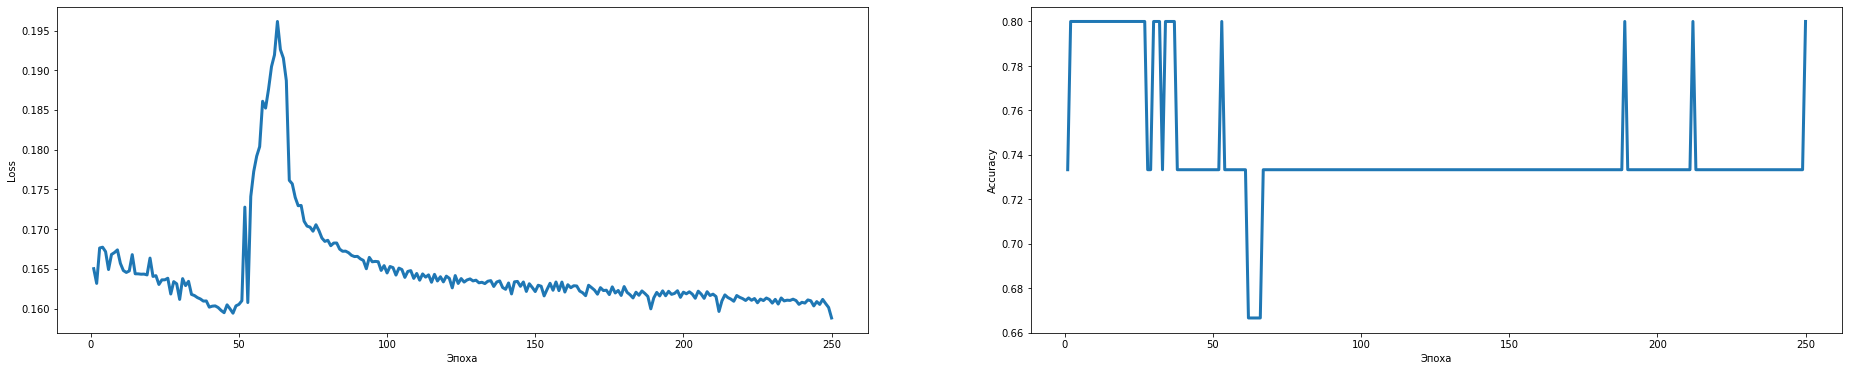

In [ ]:
plt.figure(figsize = (32, 6))
plt.subplot(1,2,1)#в зависимости от эпохи как изменяется расчет значений потери 
plt.plot(range(1 , len(array_loss_bp) + 1, 1), array_loss_bp, linewidth = 3)
plt.xlabel("Эпоха")
plt.ylabel("Loss")

plt.subplot(1,2,2)#в зависимости от эпохи как изменяется точность
plt.plot(range(1 , len(array_acc_bp) + 1, 1), array_acc_bp, linewidth = 3)
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")